# Imports

In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np

from skimage.feature import hog
from skimage import data, exposure
from skimage.color import rgb2gray
from skimage.io import imread, imsave
from skimage.transform import resize

from nltk import ne_chunk, pos_tag, word_tokenize

from keras.preprocessing import image
import nltk
import pandas as pd
from skimage import img_as_ubyte
from sklearn.preprocessing import normalize
from skimage import color
from sklearn.metrics import pairwise_distances
from sklearn.feature_extraction.text import CountVectorizer
from tokenizer import tokenizer
from sklearn.metrics import pairwise_distances
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input, decode_predictions


# Hide all warnings
import warnings
warnings.filterwarnings('ignore')

print (os.getcwd(), "changing to:", os.getcwd()+"/../")

# Change this according to the path where you have the ws_toolkit
ws_toolkit_path = os.getcwd()+"/.."

os.chdir(ws_toolkit_path)
print (os.getcwd())

from ws_toolkit.utils import center_crop_image, k_neighbours

Using TensorFlow backend.


/Users/franciscorodrigues/Projects/pw_phase1/project changing to: /Users/franciscorodrigues/Projects/pw_phase1/project/../
/Users/franciscorodrigues/Projects/pw_phase1


## Pre-processing

In [2]:
import pickle

def cropImageList(images):
    croppedImages = []
    for imgName in images:
        croppedImg = []
        #Read image
        img = imread("./images/"+imgName)
        #Resize image
        croppedImg = center_crop_image(img, size=224)
        croppedImages.append(croppedImg)
    return croppedImages

#def cropImageList(images):
#    croppedImages = []
#    if not os.path.exists("cropped_images"):
#        os.mkdir("cropped_images")
#    for imgName in images:
#        croppedImg = []
#        if not os.path.exists("./cropped_images/"+imgName):
#            #Read image
#            img = imread("./images/"+imgName)
#            #Resize image
#            croppedImg = center_crop_image(img, size=224)
#            #Save image
#            imsave(fname="./cropped_images/"+imgName, arr=croppedImg, quality=100)
#        else:
#            croppedImg = imread("./cropped_images/"+imgName)
#        croppedImages.append(croppedImg)
#    return croppedImages

# Read Data

In [3]:
df = pd.read_csv("./visualstories_edfest_2016_twitter_xmedia.csv", sep=';', encoding="utf-8")

data = np.array([df.get("text").values, df.get("image-url").values])
# This are the text of the tweets
tweets = data[0]
# This are the links of the images of the tweets (ex: C0zsADasd213.jpg)
imageLinks = [i.replace('https://pbs.twimg.com/media/', '') for i in data[1]]
# This are the arrays of the data of each cropped image
croppedImages = cropImageList(imageLinks)
testCrop = croppedImages[:]

# Bag of Words search space

Original query: Edinburgh Castle is one of the main attractions

#Edinburgh castle #Edinburgh sunset #EdinburghFestival pic.twitter.com/prXyjqf9Mo


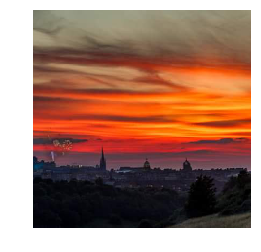

Edinburgh Castle #DeepTime #Edinburgh #edfest via http://ift.tt/1qC8Qxm pic.twitter.com/qVGNuCTDlc


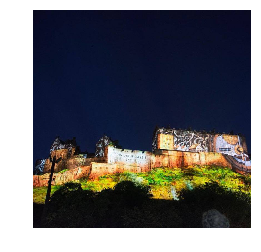

Edinburgh castle overlooking grassmarket #edfringe pic.twitter.com/K4M7fmcPXe


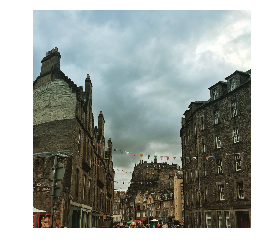

Beautiful Edinburgh Castle  #edfringe #scotlandpic.twitter.com/BncX39N619


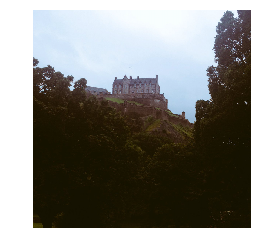

Castle show kicks off Edinburgh festival http://dlvr.it/LzMv9x pic.twitter.com/L4gugHwK0p


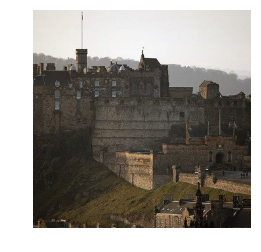

This week's cultural light show courtesy of Edinburgh Castle #edfest pic.twitter.com/egGaouUhpD


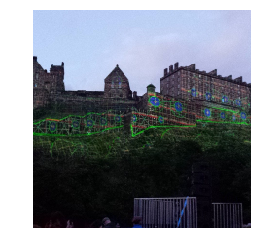

Photo from digital light show @ Edinburgh Castle last night marking the opening of 2016 Edinburgh Festival #DeepTimepic.twitter.com/bVoSjcAP1u


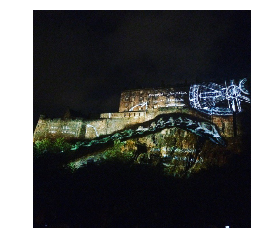

All done for 2016 #EdFringe pic.twitter.com/bPdlqYo5yB – em Edinburgh Castle


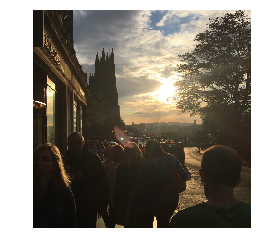

Good but cold times @EdinburghTattoo The castle looked a wee bit like wedding cake. @edinburghfest pic.twitter.com/8wHjFSbHOk – em Edinburgh Castle


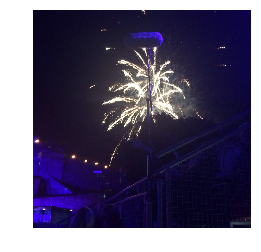

Now there's a sight you don't see everyday. #Edinburgh castle #edfringe  pic.twitter.com/ftqNcn7Db2


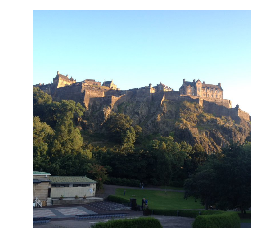

In [4]:
def init_bow(texts, tknzr):
    vectorizer = CountVectorizer(stop_words="english", min_df=3, binary=False, tokenizer=tknzr.tokenize)
    texts_bow = vectorizer.fit_transform(texts)
    vocabulary = vectorizer.vocabulary_
    #print("Vocabulary size: {}".format(len(vocabulary)))
    texts_bow = normalize(texts_bow, norm="l2")    
    return vectorizer, texts_bow

def bow_query(vectorizer, query):
    # Transform query in a BoW representation
    query_bow = vectorizer.transform([query])
    query_bow = normalize(query_bow, norm="l2")   
    return query_bow

def print_results(_results, _query):
    print("Original query: {}\n".format(_query))
    for r in _results:
        print("{0}".format(r[2]))
        plt.imshow(croppedImages[r[0]])
        plt.axis('off')
        plt.show()

# Bad resulsts
#from nltk.tokenize import TreebankWordTokenizer
#tknzr = TreebankWordTokenizer()

# Good results but doesn't have method to remove links
#from nltk.tokenize import TweetTokenizer
#tknzr = TweetTokenizer(strip_handles=True, preserve_case=False)

# Very Good Resulsts, probably because urls and handles are removed

def execute_bow(_queryText, _dataTexts, _dataImages, _metric="cosine", _k=10, _handles=False, _hashes=False, _case=False, _url=False):
    tknzr = tokenizer.TweetTokenizer(preserve_handles=_handles, preserve_hashes=_hashes, preserve_case=_case, preserve_url=_url)
    vectorizer, texts_bow = init_bow(tweets, tknzr)
    query_bow = bow_query(vectorizer, query)
    k_nearest_indexes, k_nearest_dists = k_neighbours(q=query_bow, X=texts_bow, metric="cosine", k=10)
    results = list(zip(k_nearest_indexes,k_nearest_dists, [tweets[i] for i in k_nearest_indexes],[imageLinks[i] for i in k_nearest_indexes]))
    print_results(results, _queryText)
    
query = "Edinburgh Castle is one of the main attractions"

execute_bow(query, tweets, imageLinks)

# Histogram of Colors (HoC) search space

Query image: 765986455512645632.jpg


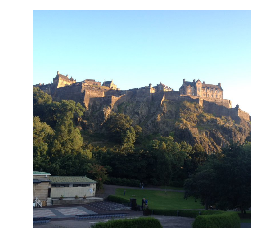

#1276 - 0.0 - CqFUmNnWAAAfOxg.jpg


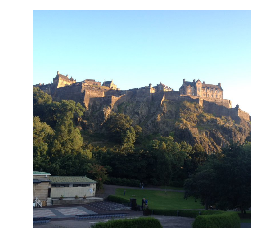

#256 - 0.7122152509749617 - CqYMeVPWAAAoEJT.jpg


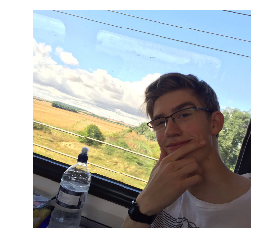

#1286 - 0.7392980616336715 - CqELMFxWgAAm1fU.jpg


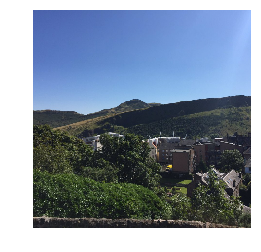

#1658 - 0.7926192548552058 - Cq8XjdDW8AAm1NM.jpg


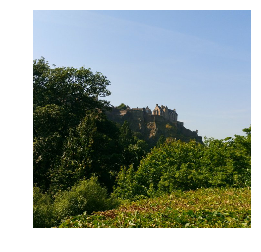

#1853 - 0.8160799118249831 - CpcOVreWEAIJsNT.jpg


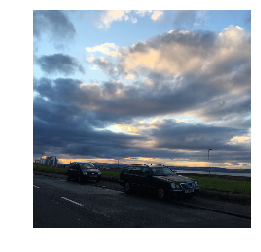

#1489 - 0.8271565402488393 - CqDxi77XEAA3oYP.jpg


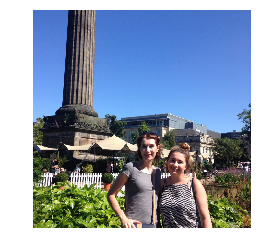

#1727 - 0.8326029401133014 - Cp7CJkoWAAAkp_T.jpg


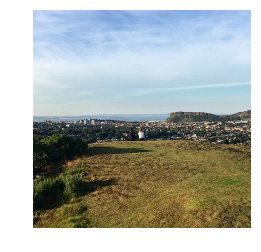

#456 - 0.8567917354348457 - Cp9vqZoW8AAApOO.jpg


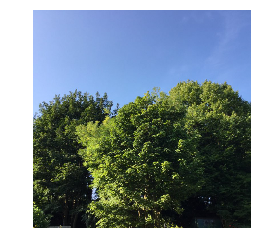

#1985 - 0.8583413071800016 - CsfkL2EXEAAxdRH.jpg


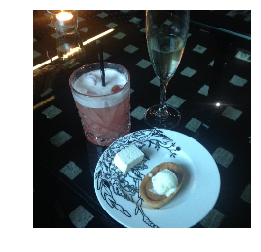

#1537 - 0.8595736988948645 - CpSMbQUW8AEV5mm.jpg


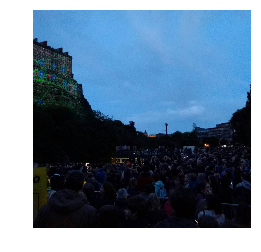

In [5]:
def hoc(im, bins=(16,16,16), hist_range=(256, 256, 256)):
    im_r = im[:,:,0]
    im_g = im[:,:,1]
    im_b = im[:,:,2]
    
    red_level = hist_range[0] / bins[0]
    green_level = hist_range[1] / bins[1]
    blue_level = hist_range[2] / bins[2]
    
    im_red_levels = np.floor(im_r / red_level)
    im_green_levels = np.floor(im_g / green_level)
    im_blue_levels = np.floor(im_b / blue_level)
    
    ind = im_blue_levels*bins[0]*bins[1]+ im_green_levels*bins[0] + im_red_levels
    
    hist_r, bins_r = np.histogram(ind.flatten(), bins[0]*bins[1]*bins[2])
    
    return hist_r, bins_r

def getColorMatrix(_croppedImages, _bins=(4,4,4)):    
    #Histogram of colors results
    feats = []
    for img in _croppedImages:    
        # Change image color space from RGB to HSV. 
        # HSV color space was designed to more closely align with the way human vision perceive color-making attributes
        img_hsv = color.rgb2hsv(img)    
        # convert image pixels to [0, 255] range, and to uint8 type
        img_int = img_as_ubyte(img_hsv)
        # Extract HoC features
        hist, bin_edges = hoc(img_int, bins=_bins)    
        # Normalize features
        # We add 1 dimension to comply with scikit-learn API
        hist = np.squeeze(normalize(hist.reshape(1, -1), norm="l2"))    
        feats.append(hist)    
    # Creating a feature matrix for all images
    feats = np.array(feats)
    return feats

def getQueryFeat(_queryImageId, _bins=(4,4,4)):
    img_q = imread("./query_images/" + _queryImageId)
    img_q_hsv = center_crop_image(img_q, size=224)
    img_q_hsv = color.rgb2hsv(img_q_hsv)
    img_int = img_as_ubyte(img_q_hsv)
    hist, bin_edges = hoc(img_int, bins=_bins)
    image_q_feat = np.squeeze(normalize(hist.reshape(1, -1), norm="l2"))
    return image_q_feat

def getNearestHoC(_dataImages, _queryImageFeat, _colorMatrix, _metric="euclidean", _k=10):
    # Use the implemented function to find the K nearest neighbours on the HoC image vector space.
    k_nearest_indexes, k_nearest_dists = k_neighbours(q=_queryImageFeat.reshape(1,-1), X=_colorMatrix, metric=_metric, k=_k)
    # Inspecting the top-k results - list of tuples (image index, distance to query image, image name)
    results = list(zip(k_nearest_indexes, k_nearest_dists, [_dataImages[i] for i in k_nearest_indexes]))
    return results

def print_results_hoc(_results, _queryImageId):
    print("Query image: {}".format(_queryImageId))
    img = imread("./query_images/"+_queryImageId)
    img = center_crop_image(img, size=224)
    plt.imshow(img)
    plt.axis('off')
    plt.show()
    for r in _results:
        print("#{} - {} - {}".format(r[0], r[1], r[2]))
        plt.imshow(croppedImages[r[0]])
        plt.axis('off')
        plt.show()

def execute_hoc(_queryImageId, _dataTexts, _dataImages, _metric="euclidean", _k=10, _bins=(4,4,4)):
    colorMatrix = getColorMatrix(croppedImages, _bins)
    image_q_feat = getQueryFeat(_queryImageId, _bins)
    results = getNearestHoC(_dataImages, image_q_feat, colorMatrix, _metric, _k)
    print_results_hoc(results, _queryImageId)

# Prepare image query
# try the following: image 11, image12, image13
_queryImageId = "765986455512645632.jpg"

execute_hoc(_queryImageId, tweets, imageLinks, "euclidean", 10, (4,4,4))

# Search using Histogram of Gradients (HoG)

Query image: 765986455512645632.jpg


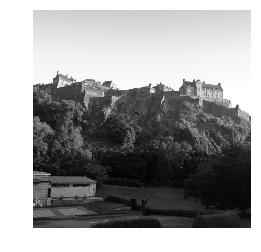

#1276 - 0.0 - CqFUmNnWAAAfOxg.jpg


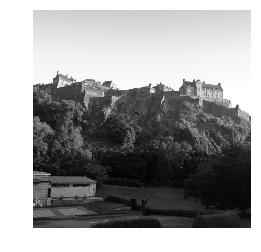

#855 - 0.466713845128239 - CpAkHamWYAEC3ss.jpg


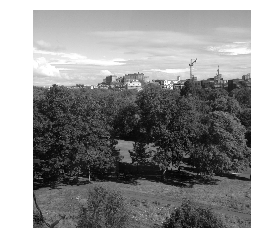

#461 - 0.5148060833867297 - Cp9N52fWIAAeR1U.jpg


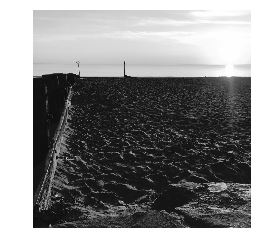

#1397 - 0.5171001284822181 - CpmKsFoWgAAtHiV.jpg


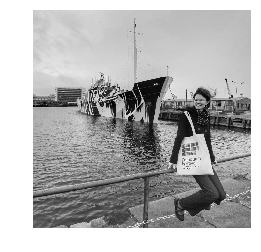

#1418 - 0.5171001284822181 - CpurYM0WgAA9zPx.jpg


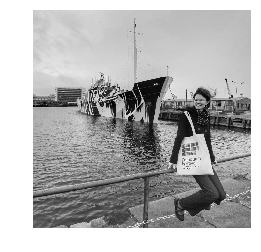

#419 - 0.5195964404715468 - CqApk15WcAAKCDT.jpg


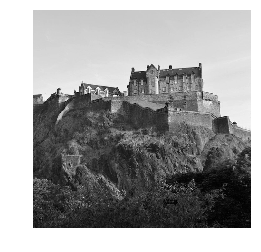

#1142 - 0.5264070410002493 - CqORNM3WcAAdKTN.jpg


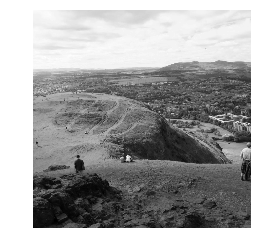

#1997 - 0.529040670394766 - CpFz6neWcAAiiBj.jpg


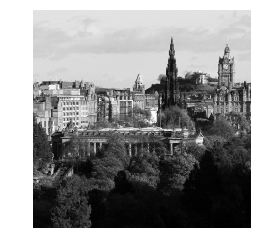

#240 - 0.5307865157633563 - CqZrAb6XEAImjTr.jpg


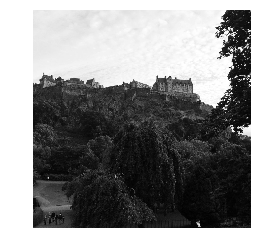

#1550 - 0.5470560425454722 - Cq5QRIeWYAAJ1RE.jpg


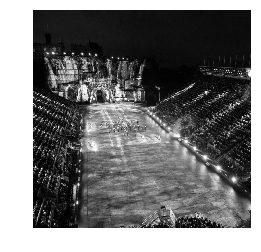

In [6]:
def getGradientMatrix(_croppedImages, _pixelsPerCell=(32,32), _orientations=8):
    gradientMatrix = []
    for img in _croppedImages:
        # Convert to grayscale
        img_gray = rgb2gray(img)   
        # Extract HoG features
        hist = hog(img_gray, orientations=_orientations, pixels_per_cell=_pixelsPerCell)   
        # Normalize features
        # We add 1 dimension to comply with scikit-learn API
        hist = np.squeeze(normalize(hist.reshape(1, -1), norm="l2"))  
        gradientMatrix.append(hist)
    # Creating a feature matrix for all images
    gradientMatrix = np.array(gradientMatrix)
    return gradientMatrix

def getQueryFeat(_queryImageId, _pixelsPerCell=(32,32), _orientations=8):
    img_q = imread("./query_images/" + _queryImageId)
    img_q = center_crop_image(img_q, size=224)
    img_q = rgb2gray(img_q)
    hist = hog(img_q, orientations=_orientations, pixels_per_cell=_pixelsPerCell)
    image_q_feat = np.squeeze(normalize(hist.reshape(1, -1), norm="l2"))
    return image_q_feat
    
def getNearestHoG(_dataImages, _queryImageFeat, _gradientMatrix, _metric="euclidean", _k=10):
    k_nearest_indexes, k_nearest_dists = k_neighbours(q=_queryImageFeat.reshape(1,-1), X=_gradientMatrix, metric=_metric, k=_k)
    results = list(zip(k_nearest_indexes, k_nearest_dists, [_dataImages[i] for i in k_nearest_indexes]))
    return results

def print_results_hog(_results, _queryImageId):
    print("Query image: {}".format(_queryImageId))
    img = imread("./query_images/"+_queryImageId)
    img = rgb2gray(center_crop_image(img, size=224))
    plt.imshow(img, cmap=plt.cm.gray)
    plt.axis('off')
    plt.show()
    for r in _results:
        img = rgb2gray(croppedImages[r[0]])
        print("#{} - {} - {}".format(r[0], r[1], r[2]))
        plt.imshow(img, cmap=plt.cm.gray)
        plt.axis('off')
        plt.show()

def execute_hog(_queryImageId, _dataTexts, _dataImages, _metric="euclidean", _k=10, _pixelsPerCell=(32,32), _orientations=8):
    gradientMatrix = getGradientMatrix(croppedImages, _pixelsPerCell, _orientations)
    image_q_feat = getQueryFeat(_queryImageId)
    results = getNearestHoG(_dataImages, image_q_feat, gradientMatrix, _metric, _k)
    print_results_hog(results, _queryImageId)
    
query = "765986455512645632.jpg"

execute_hog(query, tweets, imageLinks, "euclidean", 10, (32,32), 8)

# CNN search space

In [7]:
from sklearn.preprocessing import MultiLabelBinarizer
import time

def process_images_keras(_images, _folder="./images/"):
    processedImgs = []
    for imgId in _images:
        # We are loading each image using Keras image and specifying the target size.
        img = image.load_img(_folder + imgId, target_size=(224, 224))

        # Then the function img_to_array converts a PIL (library used by Keras) to a numpy array
        x = image.img_to_array(img)

        # A one dimension is added to the the numpy array (224x224x3) becomes (1x224x224x3)
        x = np.expand_dims(x, axis=0)

        # Apply Keras pre-processing steps specific to VGG16 model
        x = preprocess_input(x)
        processedImgs.append(x)
    return processedImgs


# Greate Tags BoW representation for all entries in dataset
def getTagsBow(_dataImages):
    start = time.time()
    img_list = process_images_keras(_dataImages)
    end = time.time()
    print("Processed Images finished: {}".format(end - start))
    model = VGG16(weights='imagenet', include_top=True)
    #model = ResNet50(weights='imagenet')
    # Convert from list to ndarray
    img_array_list = np.vstack(img_list)
    # Feed all images to the model
    start = time.time()
    preds = model.predict(img_array_list)
    end = time.time()
    print("Model Predictions finished: {}".format(end - start))
    #print("Resulting shape of the network output: {}".format(preds.shape))
    concepts = decode_predictions(preds, top=5)
    # Experiment with this parameter
    k = 5
    # Get the top K most probable concepts per image
    sorted_concepts =  np.argsort(preds, axis=1)[:,::-1][:,:k]
    data_tags = concepts
    mlb = MultiLabelBinarizer(classes=range(0,1000))
    tags_bow = mlb.fit_transform(sorted_concepts)
    #print(tags_bow.shape)
    return model, concepts, mlb, tags_bow, data_tags

# Create Tags BoW representation from query
def getQueryBow(_queryImageId, _model, _mlb, _k=10):
    print("Query", _queryImageId)
    query_list = process_images_keras([_queryImageId], "./query_images/")
    query_array_list = np.vstack(query_list)
    pred_query = _model.predict(query_array_list)
    query_sorted_concepts = np.argsort(pred_query, axis=1)[:,::-1][:,:_k]
    query_bow = _mlb.transform(query_sorted_concepts)
    query_tags = decode_predictions(pred_query, top=5)
    return query_bow, query_tags

def getNearestCNN(_dataImages, _queryBow, _tagsBow, _metric="cosine", _k=10):
    k_nearest_indexes, k_nearest_dists = k_neighbours(q=_queryBow, X=_tagsBow, metric=_metric, k=_k)
    results = list(zip(k_nearest_indexes,k_nearest_dists, [_dataImages[i] for i in k_nearest_indexes]))
    return results

def print_results_cnn(_results, _tags, _queryImageId, _queryTags):
    print("Query image: {}".format(_queryImageId))
    print("{}".format(_queryTags))
    plt.imshow(imread("./query_images/"+_queryImageId))
    plt.axis('off')
    plt.show()
    for r in _results:
        print("{} - {} - {}".format(r[0],r[1],r[2]))
        print("{}".format(_tags[r[0]]))
        plt.imshow(croppedImages[r[0]])
        plt.axis('off')
        plt.show()

def execute_vgg_16(_queryImageId, _dataTexts, _dataImages, _metric="cosine", _k=10):
    model, concepts, mlb, tags_bow, data_tags = getTagsBow(_dataImages)
    query_bow, query_tags = getQueryBow(_queryImageId, model, mlb)
    results = getNearestCNN(_dataImages, query_bow, tags_bow, _metric, _k)    
    print_results_cnn(results, data_tags, _queryImageId, query_tags)

# Print Query
queryId = "bird.jpg"

# Print Results
#execute_vgg_16(queryId, tweets, imageLinks, "cosine", 10)

# Search by Bag of Entities

Original: Edinburgh Castle is one of the main attractions
Entities: ['Edinburgh', 'Castle']

#1257
0.0
Original: ['Edinburgh', 'Castle', 'Brexit']
Entities: CpUaBEeXYAAgllE.jpg


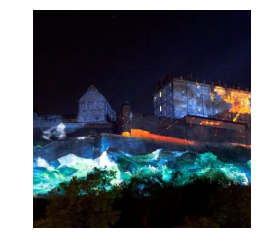

#1983
0.0
Original: ['Castle', 'Edinburgh']
Entities: CpQO-pVUMAA4oad.jpg


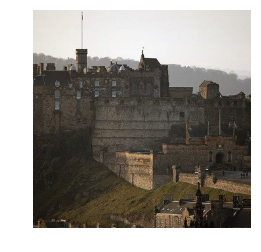

#879
0.2928932188134524
Original: ['Edinburgh']
Entities: CqtHnmFWEAESmM5.jpg


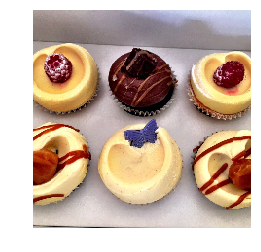

#873
0.2928932188134524
Original: ['Edinburgh']
Entities: CquosevW8AABAFS.jpg


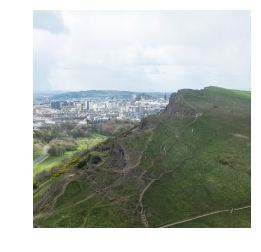

#835
0.2928932188134524
Original: ['Edinburgh']
Entities: CpCiZIuXYAAi42J.jpg


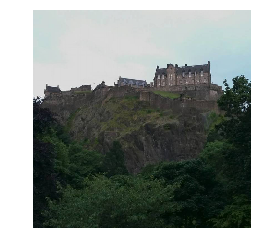

#834
0.2928932188134524
Original: ['Edinburgh']
Entities: CpCnaGkWIAA_Qkg.jpg


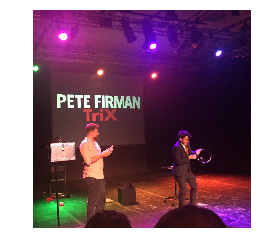

#809
0.2928932188134524
Original: ['Edinburgh']
Entities: CrCw6EAWcAEXdt_.jpg


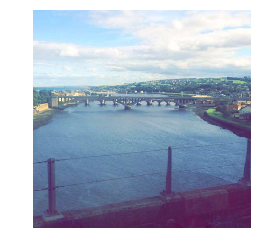

#804
0.2928932188134524
Original: ['Calton Hill', 'Edinburgh', 'City', 'Edinburgh']
Entities: CrDQQ4CW8AAfJfv.jpg


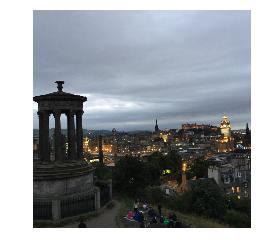

#781
0.2928932188134524
Original: ['Halfway', 'Edinburgh']
Entities: CpQWxVDWgAAFGAW.jpg


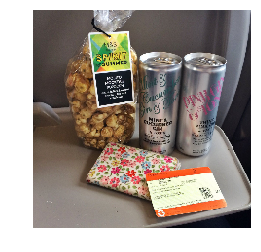

#769
0.2928932188134524
Original: ['Edinburgh']
Entities: CpRC0pbXgAEHSDT.jpg


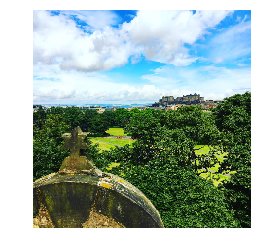

In [13]:
def extract_named_entities(sentence, _handles=False, _hashes=False, _case=True, _url=False):
    tweetTokenizer = tokenizer.TweetTokenizer(preserve_handles=_handles, preserve_hashes=_hashes, preserve_case=_case, preserve_url=_url)
    # Using the 3rd party tweet aware tokenizer produces better results because sometimes information in handles and tags are important
    # Also the trimming of links is a usefull way to reduce the vocabulary
    tknzr = tweetTokenizer.tokenize
    # The Word Tokenizer default can't really efficiently tokenize some of the tweet text and leads to useless terms that 99% of the time don't qualify
    # as entities even tho there is information in the tweet that is for sure an entity
    # it also tokenizes links which can lead to similarities that are not relevant and misdirect the search. ex: pic.twitter.com as a token, every tweet has one
    # so it will misdirect the vector distance calculation making it think that the tweets share some useful info
    #tknzr = word_tokenize
    ners = []
    for sent in nltk.sent_tokenize(sentence):
        for chunk in nltk.ne_chunk(nltk.pos_tag(tknzr(sent))):
            if hasattr(chunk, 'label'):
                ners.append(' '.join(c[0] for c in chunk))
    return ners

# It is almost the same as the generic BoW approach, but in this case we use a function as the tokenizer for the
# vectorization, and to avoid doing special code to make the function more generic we just use it like this
def init_bow(texts, func, args):
    vectorizer = CountVectorizer(stop_words="english", min_df=3, binary=False, lowercase=False, tokenizer=lambda text: func(text, **args))
    #vectorizer = CountVectorizer(stop_words="english", min_df=3, binary=False, lowercase=False, tokenizer=func)
    texts_bow = vectorizer.fit_transform(texts)
    vocabulary = vectorizer.vocabulary_
    #print("Vocabulary size: {}".format(len(vocabulary)))
    texts_bow = normalize(texts_bow, norm="l2")
    
    return vectorizer, texts_bow

def bow_query(vectorizer, query):
    # Transform query in a BoW representation
    query_bow = vectorizer.transform([query])
    query_bow = normalize(query_bow, norm="l2")
    
    return query_bow

# Uses TwitterTokenizer as the tokenizer to create the vocabulary for the BoW
# The input is the entitites of the tweets concateneted as a sentence
# Problem? ex. "Michael Jackson" tokenizesas-> "Michael" "Jackson"
# May lead to some search problems, but it still a good solution to search

#vectorizer, texts_bow = init_bow(tweetsEntities, tknzr)

# Uses the complete entities as vocabulary
# Good! ex. "Michael Jackson" tokenizesas-> "Michael Jackson"
# It is more context aware regarding the entity types supported


def print_results_entities(_results, _queryText):
    query_entities = extract_named_entities(_queryText)
    print("Original: {}\nEntities: {}\n".format(_queryText, query_entities))
    for r in _results:
        print("#{}\n{}\nOriginal: {}\nEntities: {}".format(r[0], r[1], r[2], r[3]))
        plt.imshow(croppedImages[r[0]])
        plt.axis('off')
        plt.show()

def execute_boe(_queryText, _dataTexts, _dataImages, _metric="cosine", _k=10, _handles=False, _hashes=False, _case=True, _url=False):
    vectorizer, texts_bow = init_bow(_dataTexts, extract_named_entities, {"_handles": _handles, "_hashes": _hashes, "_case": _case, "_url":_url})
    query_bow = bow_query(vectorizer, _queryText)
    k_nearest_indexes, k_nearest_dists = k_neighbours(q=query_bow, X=texts_bow, metric="cosine", k=10)
    results = list(zip(k_nearest_indexes,k_nearest_dists, [extract_named_entities(_dataTexts[i]) for i in k_nearest_indexes], [imageLinks[i] for i in k_nearest_indexes]))
    print_results_entities(results, _queryText)
    
query = "Edinburgh Castle is one of the main attractions"

execute_boe(query, tweets, imageLinks)